# Background:
Your company is in the process of developing a mod for Dota 2 which will allow to predict win/loss outcomes of games based on team composition.

The vision of  your company is to monetize this by enabling players to build „winning teams“ and assuming that players will be open to paying for that.

When the team approaches you, they hand you a data set for building the model and hope that you‘ll save the day!


# Task:
Build a model achieving the desired outcome, quantify its performance, describe your approach and recommend a way forward to your management. 

Describe also how you would ensure, together with your Data Engineering colleagues, that the model is deployed, its performance is being monitored and it is being constantly adapted.


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5. to end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.


In [2]:
headers = ['Winner_team', 'Cluster_ID', 'Game_mode', 'Game_type']
n_heroes =  113 # data.shape[1] - len(headers)
heroes_headers =  [('hero_'+str(x)) for x in range(n_heroes)] 
heroes_headers
headers = headers + heroes_headers 

In [61]:
data_train = pd.read_csv('data/dota2Train.csv', names=headers)

In [4]:
data_train.head()

,Winner_team,Cluster_ID,Game_mode,Game_type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,...,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
data_train.tail()

,Winner_team,Cluster_ID,Game_mode,Game_type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,...,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112
92645,-1,154,2,3,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,-1,185,2,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
92649,-1,204,2,2,0,-1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_test = pd.read_csv('data/dota2Test.csv', names=headers)

In [7]:
data_test.tail()

,Winner_team,Cluster_ID,Game_mode,Game_type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,...,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112
10289,1,121,2,2,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
10290,1,154,9,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10291,1,122,9,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10292,1,152,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10293,-1,184,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


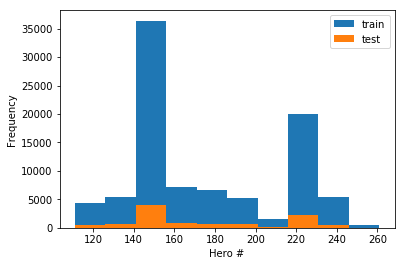

In [8]:
data_train['Cluster_ID'].plot.hist(label='train');
data_test['Cluster_ID'].plot.hist(label='test');
plt.xlabel('Hero #')
plt.legend();

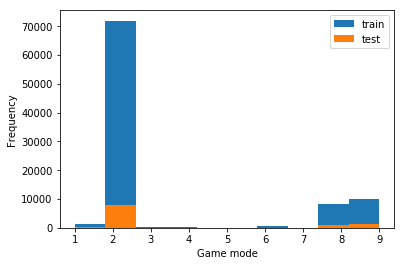

In [9]:
data_train['Game_mode'].plot.hist(label='train');
data_test['Game_mode'].plot.hist(label='test');
plt.xlabel('Game mode')
plt.legend();

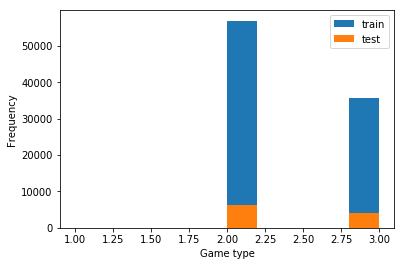

In [10]:
data_train['Game_type'].plot.hist(label='train');
data_test['Game_type'].plot.hist(label='test');
plt.xlabel('Game type')
plt.legend();

It look's like the split training/test was done properly.

In [11]:
#Sanity check
hereos_matrix = data_train.values[:,4:]
assert np.any( hereos_matrix.sum(axis=1) == 0), "Number of heroes per team doesn't match"

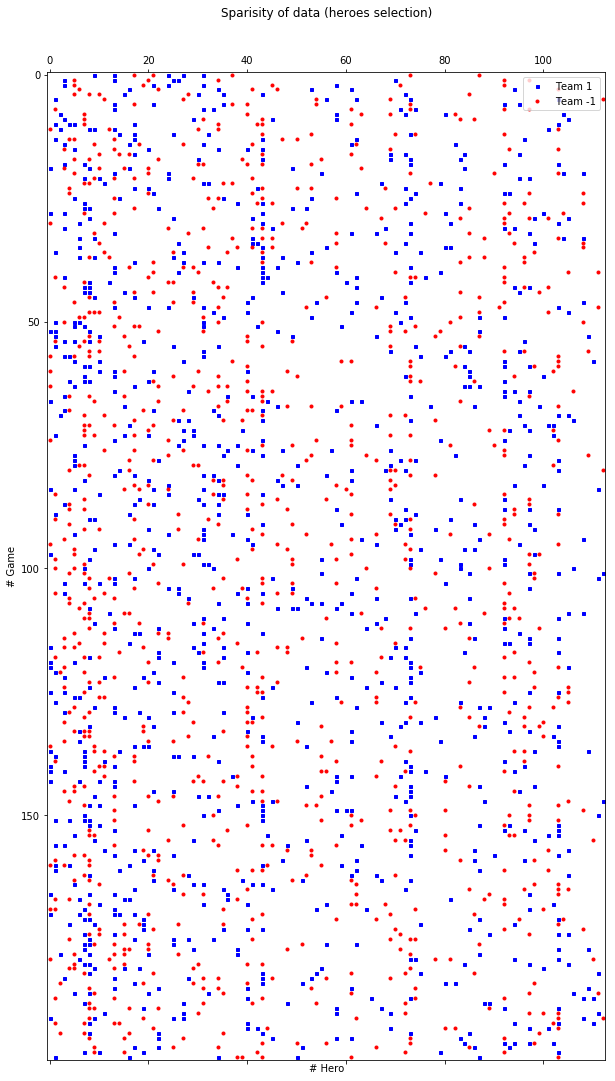

In [12]:
fig, ax = plt.subplots(figsize=(10,20))

ax.spy(hereos_matrix[:200,:]==1,
       marker='s', color='blue', markersize=3, label='Team 1');
ax.spy(hereos_matrix[:200,:]==-1,
       marker='o', color='red', markersize=3, label='Team -1');

ax.legend()
ax.set_ylabel('# Game')
ax.set_xlabel('# Hero')
ax.set_title('Sparisity of data (heroes selection)');

The high dimensionality and sparsity of the data will be a problem against common callsifiers

As for the rest of dimmensions ('Cluster_ID', 'Game_mode', 'Game_type')

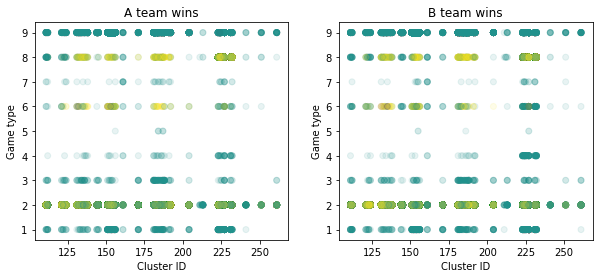

In [13]:
X = data_train.values[:,1:4]
y = data_train.values[:,0]

# TODO modify

team_A = (y == -1) # winners
team_B = (y == 1) # winners

fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(10,4))

scatt1 = ax[0].scatter(X[team_A,0], X[team_A,1], c=X[team_A,2],  alpha=0.1);
scatt2 = ax[1].scatter(X[team_B,0], X[team_B,1], c=X[team_B,2], alpha=0.1, label='Game type');

ax[0].set_title('A team wins');
ax[1].set_title('B team wins');

ax[0].set_xlabel('Cluster ID');
ax[1].set_xlabel('Cluster ID');

ax[0].set_ylabel('Game type');
ax[1].set_ylabel('Game type');

# Building a model

As a first attempt, we can exclude the Cluster_ID and Game type or mode columns since they are not scaled.

In [14]:
X = data_train.values[:,4:]
y = data_train.values[:,0]

X_test = data_test.values[:,4:]
y_test = data_test.values[:,0]

# Support vector

In [15]:
from sklearn import svm

In [16]:
clf = svm.LinearSVC(C=0.1)

In [17]:
clf.fit(X, y)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [18]:
y_pred = clf.predict(X_test)

In [19]:
y_test[:10]

array([-1,  1, -1,  1,  1,  1,  1, -1, -1, -1], dtype=int64)

In [20]:
y_pred[:10]

array([-1,  1,  1,  1, -1, -1, -1,  1, -1, -1], dtype=int64)

In [21]:
def myscore(pred, truth):
    score = np.sum(pred==truth)/ len(truth)
    return score

In [22]:
myscore(y_pred, y_test)

0.5975325432290655

60% of winning might look like something promising, but:

In [23]:
y_random = np.random.choice([-1,1], size=len(y_pred))

In [24]:
myscore(y_random, y_test)

0.4982514085875267

A random guess will give us a 50% chance of winning.

Having >100 dimmensions and with that level of sparisty it means that we are probably under the curse of dimensionality

Let's try to optimize our model parameters:

In [25]:
# Now we need to fit a classifier for all parameters 
# (we use a smaller set of parameters here because it takes a while to train)
X = data_train.values[:1000,4:]
y = data_train.values[:1000,0]

# X_test, y_test (unchainged)

In [26]:
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [27]:
# Cross-validation (setup)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42) 

# Grid search
C_range = np.logspace(-1, 3, 5)
gamma_range = np.logspace(-4, 0, 5)

param_grid = dict(gamma=gamma_range, C=C_range)
# param_grid = dict(C=C_range)

grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 0.01} with a score of 0.57


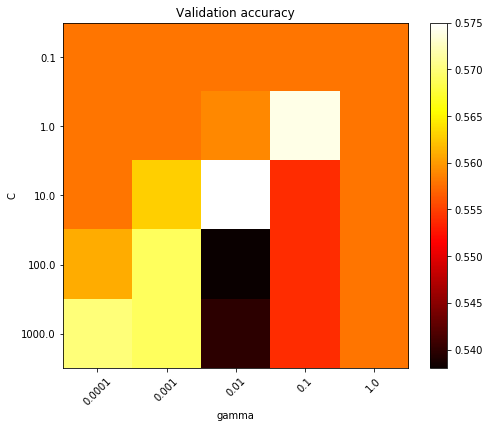

In [28]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

#scores = grid.cv_results_['mean_test_score'].reshape(len(C_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [37]:
X = data_train.values[::5,4:]
y = data_train.values[::5,0]

clf = svm.SVC(C=10, gamma=0.01)

clf.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
y_pred = clf.predict(X_test)

In [39]:
y_test[:10]

array([-1,  1, -1,  1,  1,  1,  1, -1, -1, -1], dtype=int64)

In [40]:
y_pred[:10]

array([-1,  1,  1,  1, -1, -1, -1,  1, -1, -1], dtype=int64)

In [41]:
myscore(y_pred, y_test)

0.5873324266563047

# Nearest neighbors

In [64]:
X = data_train.values[::10,4:]
y = data_train.values[::10,0]

X.shape

(9265, 113)

In [91]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,40)

train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=4, weights = 'distance',)

    # perform 3-fold cross validation
    scores = cross_val_score(knn, X, y, cv=3, scoring='accuracy')
    train_accuracy[i] = scores.mean()
    
    #Compute accuracy on the test set
    knn.fit(X,y)
    test_accuracy[i] = knn.score(X_test, y_test) 
    


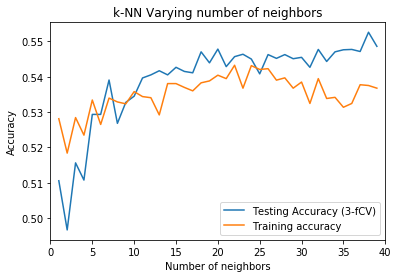

In [93]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy (3-fCV)')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlim([0,40])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

To address the inefficiencies of KD Trees in higher dimensions or the unfeasibility of using brute force to calculate the distances between all pairs of poitns, the ball tree data structure will be used.

# Random forests

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
X = data_train.values[:,4:]
y = data_train.values[:,0]

In [46]:
clf = ExtraTreesClassifier(n_estimators=1000, n_jobs=4)
clf.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
y_pred = clf.predict(X_test)

In [48]:
myscore(y_pred, y_test)

0.5346803963473868

In [49]:
importances = clf.feature_importances_

In [50]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

In [51]:
indices = np.argsort(importances)[::-1]

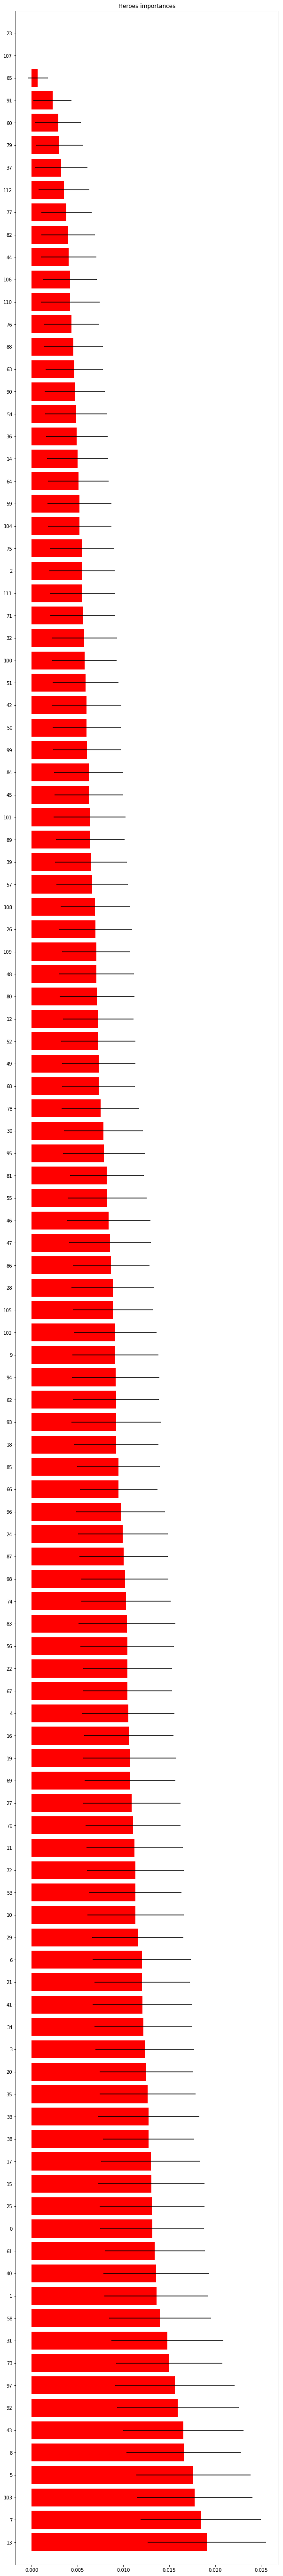

In [52]:
# Print the feature ranking
# print("Heroe ranking:")

# for f in range(X.shape[1]):
#     print("%d. Hereo %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,100))
plt.title("Heroes importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

# Why this is not working? 

One of the variables we are not measuring is the skills of the players. Given the sparsity of the data (high number of heroes) and the lack of fit, we can try a different approach. We may be tempeted to reduce the dimensionality to find the 'best' herores (more likely to win) as the plot from above suggests. 

In [53]:
from sklearn.decomposition import IncrementalPCA

In [54]:
ipca = IncrementalPCA(n_components=2, batch_size=3)

In [55]:
ipca.fit(X)

IncrementalPCA(batch_size=3, copy=True, n_components=2, whiten=False)

In [56]:
X_ipca = ipca.transform(X) 
X_ipca

array([[ 0.48624478,  1.4320879 ],
       [-0.21204654,  1.19453067],
       [-0.08212886,  0.61689947],
       ...,
       [-0.18692559,  0.10072109],
       [-0.28502575, -0.51413483],
       [ 0.37645108,  0.35624932]])

Text(0.5,1,'B team wins')

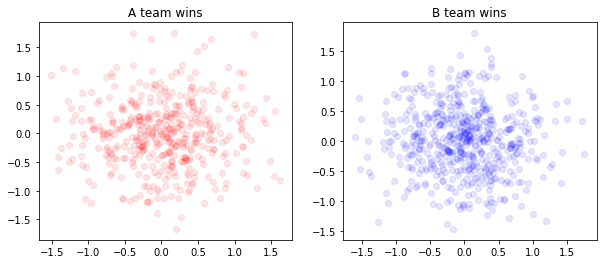

In [57]:
team_A = (y == -1) # winners
team_B = (y == 1) # winners

fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(10,4))

ax[0].scatter(X_ipca[team_A,0], X_ipca[team_A,1], color='red',  alpha=0.1)
ax[1].scatter(X_ipca[team_B,0], X_ipca[team_B,1], color='blue', alpha=0.1)

ax[0].set_title('A team wins')
ax[1].set_title('B team wins')


There is no a clear pattern to reduce the dimmensions by best heroes (A and B look the same)

Text(0.5,1.05,'Sparisity of data, it looks like there is some freq.')

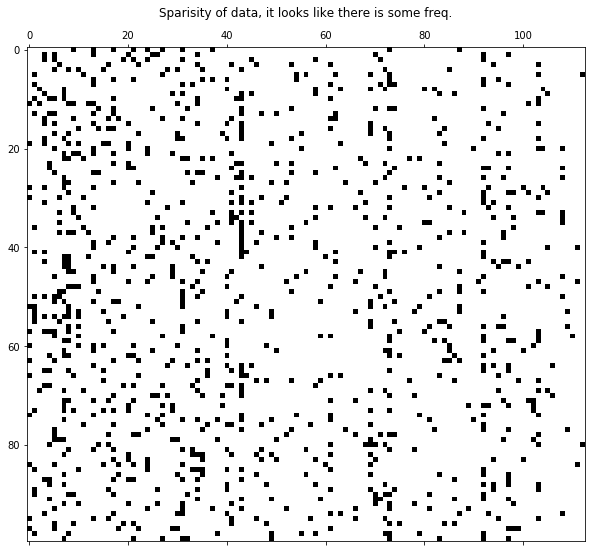

In [58]:
plt.figure(figsize=(10,20))
plt.spy(X[:100,:]);
plt.title('Sparisity of data, it looks like there is some freq.')

In [59]:
n_selections = np.abs(X).sum(axis=0)

In [60]:
p_selections = n_selections/n_selections.max()

In [61]:
indices_sel = np.argsort(p_selections)[::-1]

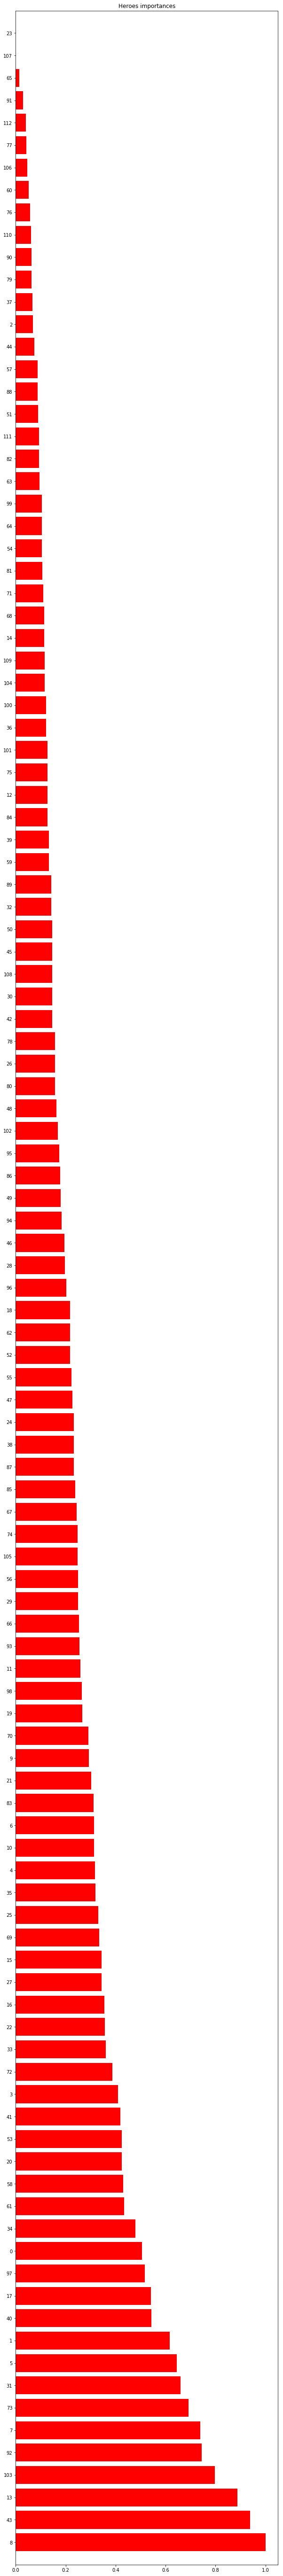

In [62]:
plt.figure(figsize=(10,100))

plt.title("Heroes importances")

plt.barh(range(X.shape[1]), p_selections[indices_sel],
       color="r", align="center")
plt.yticks(range(X.shape[1]), indices_sel)
plt.ylim([-1, X.shape[1]])
plt.show()

In [63]:
indices[:10] # best 10 heroes given by random forest

array([ 13,   7, 103,   5,   8,  43,  92,  97,  73,  31], dtype=int64)

In [64]:
indices_sel[:10] # top 10 heroes more often selected

array([  8,  43,  13, 103,  92,   7,  73,  31,   5,   1], dtype=int64)